# Extraction de la liste des polluants

### Context
- Pour rappel, on exploite principalement une source de donnée qu'on appelle EDC, lire plus dans le wiki/outline. Les fichiers sont importés par l'équipe data eng dans la BDD duckdb, donc vous pouvez exploiter les tables directement. Il y a un notebook example.
- Dans les spécifications du livrable, on dit qu'on va vouloir catégoriser les polluants qui apparaîtront sur la carte pour faciliter sa lecture
    - cette catégorisation sera faite, ou à minima validée, par Générations Futures, car nécessite une expertise forte sur le sujet
    - e.g., de catégories attendues : Pesticides et métabolites, PFAS, Nitrate, CVM (cf article du Monde et site ministère de la santé), HAP, résidus d’explosifs (pb majeur en région Nantaise par exemple), métaux lourds, Autres catégories à définir :médicaments, perchlorate (bcp d’appels de journalistes sur les perchlorate)
- C'est une tâche exploratoire, plusieurs bénévoles peuvent travailler dessus car chaque personne va peut-être explorer le problème différemment. C'est OK! Faire un notebook par bénévole.

### Tâche
- extraire la liste des polluants recherchés dans les prélèvements
- sortir des premières analyses de ces données
    - disponibilité de la donnée
        - couverture du territoire : pour chaque polluant, quelle est la part des UDI avec analyse de chaque polluant
        - périodicité : pour chaque polluant, à quelle fréquence collecte-t-on
    - visualisation sur carte de la donnée pour chaque polluant. (obj : avoir une idée de la distribution, des valeurs min max etc)
    - c'est peut-être too much, analyse des polluants par seuils de dépassement

### Livrable
- Notebook permettant de reproduire l'analyse / reproduire le fichier
- Excel de résultats de l'exploration à partager à Pauline
- Et partager vos infos sur Slack aux autres bénévoles data analysts (ne pas spam, donc faire un cours message puis détailler dans le thread)

Si vous êtes perdu/débutant: Guide pour commencer sur la périodicité

- Isoler les dates des prélèvements: compter le nb de prélèvements totaux par date (ex: le 01/01/2025 il y a eu X prélèvements sur l’ensemble du territoire)
- Filtrer le nb de prélèvements par paramètre (ex: le 01/01/2025 le composé Y a été mesuré X fois)
- Filtrer le nb de prélèvements par UDI (ex: le 01/01/2025 X prélèvements ont été effectués dans l’UDI Z)
- Filtrer le nb de prélèvements par UDI et par paramètre (ex: le 01/01/2025 le composé Y a été mesuré X fois dans l’UDI Z)
    - (a) Agréger les données des points précédents pour obtenir les infos par commune, par circonscription, par département puis par région (ex: le 01/01/2025 le composé Y a été mesuré X fois dans la commune W) - dépend des tâches précédentes
    - (b) Agréger les données du point (a) pour obtenir les infos à l’échelle de la semaine, du mois ou de l’année. Le symbole / signifie “ou”. $$$ Fonction qui prend en argument le dataframe en sortie de (a) (version France, région, département ou commune), un chiffre donnant l’échelle géographique concernée (1: France, 2: Région, 3: Département, 4: Commune), un chiffre donnant l’échelle temporelle souhaitée (0: semaine, 1: mois, 2: année). La fonction retourne un dataframe avec les infos suivantes: le chiffre (1: France, 2: Région, 3: Département, 4: Commune), Rien/Numéro département/Numéro de Région/Code Postal de la commune, La semaine(Nombre de 1 à 52)/le Mois/l’année, cdparametre, Nombre de prélèvements sur la période $$$ - dépend des tâches précédentes
- Afficher un Dashboard interactif à l’aide de l’outil Evidence qui permet de sélectionner une échelle géographique (France, Région, Département, Circonscription, Commune), une échelle temporelle (Année, Mois, Semaine) et un paramètre (Tous les paramètres OU Liste de chaque paramètre en toutes lettres) et affiche le nombre de prélèvements effectués (calendrier avec une échelle de couleur selon le nombre de prélèvements?)

#### Chargement de la base

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import duckdb

con = duckdb.connect(database="./../../database/data.duckdb", read_only=True)

### Affichage des tables

In [11]:
query = """
SELECT *
FROM sise_resultats
WHERE qualitparam = 'O'
  AND cddept = '075'
LIMIT 10
"""
df_filtered = con.execute(query).df()

In [12]:
df_filtered

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl
0,075,07500206806,ASP,6489,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect normal,SANS OBJET,X,None,None,0.0,None,07500206771
1,075,07500206806,COULQ,5900,COULEUR (QUALITATIF),Couleur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.0,None,07500206771
2,075,07500206806,ODQ,5901,ODEUR (QUALITATIF),Odeur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.0,None,07500206771
3,075,07500206806,SAVQ,5902,SAVEUR (QUALITATIF),Saveur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.0,None,07500206771
4,075,07500206810,ASP,6489,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect normal,SANS OBJET,X,None,None,0.0,None,07500206775
5,075,07500206810,COULQ,5900,COULEUR (QUALITATIF),Couleur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.0,None,07500206775
6,075,07500206810,ODQ,5901,ODEUR (QUALITATIF),Odeur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.0,None,07500206775
7,075,07500206810,SAVQ,5902,SAVEUR (QUALITATIF),Saveur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.0,None,07500206775
8,075,07500206811,ASP,6489,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect normal,SANS OBJET,X,None,None,0.0,None,07500206776
9,075,07500206811,COULQ,5900,COULEUR (QUALITATIF),Couleur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.0,None,07500206776


In [4]:
con.table("sise_resultats").limit(5).df()

CatalogException: Catalog Error: Table with name edc_resultats does not exist!
Did you mean "sise_resultats"?
LINE 1: from edc_resultats
             ^

* Maintenant configurons l'extension SQL pour Jupyter...

%load_ext sql
%sql duckdb:///../../database/data.duckdb

Tables disponibles : 

*Le lien entre le fichier des prélèvements (PLV) et celui des résultats d’analyse (RESULT) se fait par l’intermédiaire du code du prélèvement (champ ‘referenceprel’). Le fichier UDI_COM détaille le lien entre UDI et communes et permet de pouvoir reconstituer un accès aux résultats par commune ; il est relié au fichier PLV par l’intermédiaire du champ ‘cdreseau’, correspondant au code SISE-Eaux de l’unité de distribution.*

In [3]:
con.execute("SHOW TABLES").df()

,name
0,sise_communes
1,sise_prelevements
2,sise_resultats


In [15]:
var_communes = con.sql("SELECT * FROM sise_communes;").df()
print(var_communes.dtypes)

inseecommune            object
nomcommune              object
quartier                object
cdreseau                object
nomreseau               object
debutalim       datetime64[us]
dtype: object


In [16]:
con.table("sise_communes").df().head(5)

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07
1,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07


In [17]:
var_prelevements = con.sql("SELECT * FROM sise_prelevements;").df()
print(var_prelevements.dtypes)

cddept                                object
cdreseau                              object
inseecommuneprinc                     object
nomcommuneprinc                       object
cdreseauamont                         object
nomreseauamont                        object
pourcentdebit                         object
referenceprel                         object
dateprel                      datetime64[us]
heureprel                             object
conclusionprel                        object
ugelib                                object
distrlib                              object
moalib                                object
plvconformitebacterio                 object
plvconformitechimique                 object
plvconformitereferencebact            object
plvconformitereferencechim            object
dtype: object


In [18]:
con.table("sise_prelevements").df().head(5)

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim
0,001,001000003,01007,AMBRONAY,None,None,None,00100139034,2024-01-23,11h27,Eau d'alimentation conforme aux limites de qua...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,N,C
1,001,001000003,01007,AMBRONAY,None,None,None,00100139393,2024-02-13,12h49,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
2,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100139969,2024-03-13,10h46,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
3,001,001000003,01007,AMBRONAY,None,None,None,00100140209,2024-04-05,07h27,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
4,001,001000003,01007,AMBRONAY,None,None,None,00100140543,2024-05-13,12h43,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C


con.table("sise_resultats").df().head(5)

#### Passage des tables en dataframe

In [19]:
communes = con.table("sise_communes").to_df()

In [20]:
prelevements = con.table("sise_prelevements").to_df()

### Isoler les dates des prélèvements: compter le nb de prélèvements totaux par date (ex: le 01/01/2025 il y a eu X prélèvements sur l’ensemble du territoire)

In [31]:
date_prlvmt = con.sql("""
    SELECT dateprel, COUNT(dateprel) as count_prelevements
    FROM sise_prelevements
    GROUP BY dateprel
""").df()

In [32]:
date_prlvmt

,dateprel,count
0,2024-01-02,818
1,2024-01-03,1378
2,2024-01-04,1362
3,2024-01-05,887
4,2024-01-08,2087
...,...,...
264,2024-12-23,548
265,2024-12-24,177
266,2024-12-26,128
267,2024-12-27,88


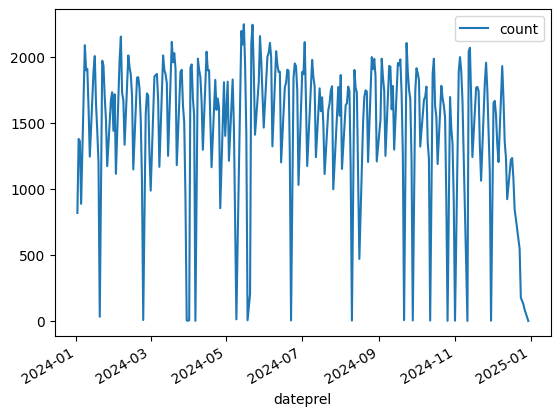

In [33]:
date_prlvmt.plot(x="dateprel", y="count_prelevements")
plt.show()

### Filtrer le nb de prélèvements par polluant

In [6]:
param_prlvmt = con.sql("""
    SELECT libmajparametre, COUNT(libmajparametre) as count_param
    FROM sise_resultats
    WHERE qualitparam = 'N'
    GROUP BY libmajparametre
    ORDER BY count_param DESC
""").df()

In [7]:
param_prlvmt

,libmajparametre,count_param
0,PH,349625
1,CONDUCTIVITÉ À 25°C,273198
2,TEMPÉRATURE DE L'EAU,266514
3,CHLORE LIBRE,265625
4,ESCHERICHIA COLI /100ML - MF,263461
...,...,...
1319,ANTIMOINE DISSOUS,1
1320,CAMPHÈNE,1
1321,CHLORE LIBRE ACTIF,1
1322,SÉLÉNIUM DISSOUS,1


In [9]:
param_prlvmt = param_prlvmt.rename(
    columns={"libmajparametre": "POLLUANT", "count_param": "NB PRELEVEMENTS"}
)

In [10]:
param_prlvmt.to_csv("liste_polluants.csv")

### Filtrer le nb de prélèvements par paramètre

In [3]:
param_prlvmt = con.sql("""
    SELECT libmajparametre, COUNT(libmajparametre) as count_param
    FROM sise_resultats
    GROUP BY libmajparametre
    ORDER BY count_param DESC
""").df()

In [4]:
param_prlvmt

,libmajparametre,count_param
0,PH,338786
1,CONDUCTIVITÉ À 25°C,265188
2,TEMPÉRATURE DE L'EAU,258858
3,CHLORE LIBRE,257631
4,ESCHERICHIA COLI /100ML - MF,255609
...,...,...
1331,STAPHYLOCOQUES PATHOGÈNES PAR 100ML,1
1332,HYDROGÈNE SULFURÉ (QUALITATIF),1
1333,MATIÈRES EN SUSPENSION,1
1334,SÉLÉNIUM DISSOUS,1


param_prlvmt.to_csv(index=False)

Il y a 1 336 paramètres qui ont été testés en 2024.

In [5]:
most_param_prlvmt = param_prlvmt.head(20)

In [15]:
most_param_prlvmt = most_param_prlvmt.rename(
    columns={"libmajparametre": "PARAMETRE", "count_param": "NB PRELEVEMENTS"}
)

<Axes: xlabel='PARAMETRE'>

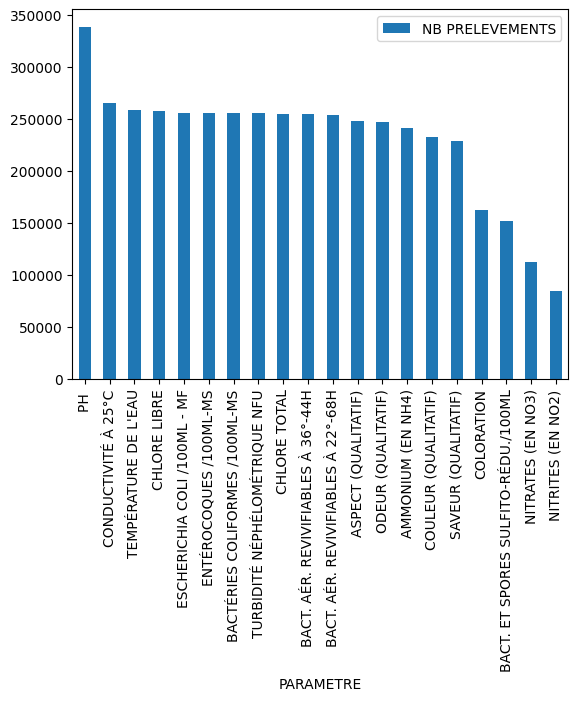

In [17]:
most_param_prlvmt.plot.bar(x="PARAMETRE", y="NB PRELEVEMENTS")

In [11]:
param_prlvmt_csv = param_prlvmt.rename(
    columns={"libmajparametre": "PARAMETRE", "count_param": "NB PRELEVEMENTS"}
)

In [ ]:
param_prlvmt_csv.to_csv("liste_polluants.csv")

### Filtrer le nb de prélèvements par paramètre et par date (ex: le 01/01/2025 le composé Y a été mesuré X fois)

In [4]:
param_prlvmt_date = con.sql("""
    SELECT dateprel, libmajparametre, COUNT(libmajparametre) as count_param
    FROM sise_prelevements P
    INNER JOIN sise_resultats R ON P.referenceprel = R.referenceprel
    GROUP BY dateprel, libmajparametre
    ORDER BY dateprel
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
param_prlvmt_date

,dateprel,libmajparametre,count_param
0,2024-01-02,ASPECT (QUALITATIF),721
1,2024-01-02,COULEUR (QUALITATIF),738
2,2024-01-02,BACTÉRIES COLIFORMES /100ML-MS,772
3,2024-01-02,ODEUR (QUALITATIF),746
4,2024-01-02,BROMATES,17
...,...,...,...
236876,2024-12-27,NITRITES (EN NO2),1
236877,2024-12-27,TRICHLOROÉTHYLÈNE,1
236878,2024-12-27,ODEUR SAVEUR (QUALITATIF),2
236879,2024-12-30,NITRATES (EN NO3),1


In [10]:
param_prlvmt_date = param_prlvmt_date.sort_values(by=["count_param"], ascending=False)

In [12]:
param_prlvmt_date.head(50)

,dateprel,libmajparametre,count_param
91886,2024-05-22,PH,2830
85306,2024-05-13,PH,2768
95996,2024-05-28,PH,2760
87961,2024-05-15,PH,2749
23307,2024-02-06,PH,2707
122392,2024-07-03,PH,2640
4162,2024-01-08,PH,2622
69170,2024-04-15,PH,2607
86605,2024-05-14,PH,2598
101707,2024-06-05,PH,2594


### Filtrer le nb de prélèvements par UDI (ex: le 01/01/2025 X prélèvements ont été effectués dans l’UDI Z)

In [48]:
udi_prlvmt = con.sql("""
    SELECT P.dateprel, P.cdreseau, C.nomcommune, COUNT(P.cdreseau) as prelevement_par_udi
    FROM sise_prelevements P
    INNER JOIN sise_communes C ON P.cdreseau = C.cdreseau
    GROUP BY P.dateprel, P.cdreseau, C.nomcommune
    ORDER BY P.dateprel
""").df()

In [49]:
udi_prlvmt

,dateprel,cdreseau,nomcommune,prelevement_par_udi
0,2024-01-02,081000818,VILLEFRANCHE-D'ALBIGEOIS,1
1,2024-01-02,081000819,SAINTE-CROIX,1
2,2024-01-02,081000815,CARMAUX,1
3,2024-01-02,081000818,TEILLET,1
4,2024-01-02,081000819,RIVIERES,1
...,...,...,...,...
906447,2024-12-27,065000794,NOUILHAN,1
906448,2024-12-27,065000794,ESCONDEAUX,1
906449,2024-12-27,065000794,CAIXON,1
906450,2024-12-27,065000794,BAZILLAC,1


### Filtrer le nb de prélèvements par UDI et par paramètre (ex: le 01/01/2025 le composé Y a été mesuré X fois dans l’UDI Z)

In [18]:
udi_param_prlvmt = con.sql("""        
    SELECT P.dateprel, P.cdreseau, C.nomcommune, COUNT(P.cdreseau) as prelevement_par_udi
    FROM sise_prelevements P
    INNER JOIN sise_communes C ON P.cdreseau = C.cdreseau
    GROUP BY P.dateprel, P.cdreseau, C.nomcommune
    ORDER BY P.dateprel
""").df()

In [ ]:
udi_param_prlvmt = con.sql("""
    SELECT P.dateprel, P.cdreseau, C.nomcommune, libmajparametre
    FROM sise_prelevements P
    INNER JOIN sise_resultats R ON P.referenceprel = R.referenceprel
    INNER JOIN sise_communes C ON P.cdreseau = C.cdreseau
    GROUP BY P.dateprel, P.cdreseau, C.nomcommune, libmajparametre
    ORDER BY P.dateprel                                         
""").df()